In this week, you are required to implement a toy GATConv and SAGEConv based on document. Also, you need to implement both in PyG and DGL. In this work, you will get a further understanding of tensor-centric in PyG and graph-centric in DGL..

## PYG

In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, remove_self_loops
from torch_geometric.utils import softmax as edge_softmax
from torch_geometric.utils import to_networkx
from torch_scatter import scatter

Data(x=[6, 4], edge_index=[2, 8], edge_attr=[8])


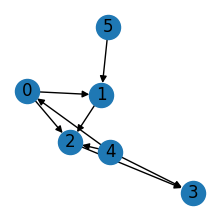

In [2]:
# 定义图
edge_index = torch.LongTensor(
    [
        [0, 0, 1, 2, 4, 4, 4, 5],
        [1, 2, 2, 3, 0, 2, 3, 1],
    ]
)
feat = torch.FloatTensor(
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4],
        [5, 5, 5, 5],
    ]
)
data = Data(x=feat, edge_index=edge_index)
edge_attr = torch.ones(data.num_edges) * 2
data.edge_attr = edge_attr

in_feats = data.num_features
out_feats = 3

print(data)
nxg = to_networkx(data)
plt.figure(figsize=(2, 2))
nx.draw(nxg, pos=nx.spring_layout(nxg), with_labels=True)

### GraphConv(GCNConv)

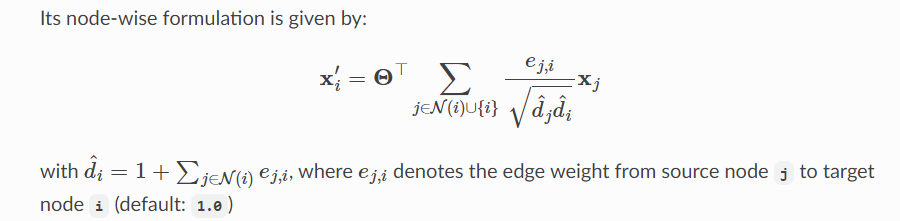

In [4]:
class PyG_GraphConv(MessagePassing):
    def __init__(self, in_feats, out_feats):
        super(PyG_GraphConv, self).__init__(aggr="add")
        self.w = nn.Linear(in_feats, out_feats, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.ones_(self.w.weight)

    def forward(self, x, edge_index, edge_attr):
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr)

        deg = degree(edge_index[1], num_nodes=x.shape[0]).view(-1, 1)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, deg=deg)
        return self.w(out)

    def message(self, x_j, edge_index, edge_attr, deg_i, deg_j, deg):
        # print(deg[edge_index[0]]==deg_j) #这两个相同的
        # print(deg[edge_index[1]]==deg_i) #这两个相同的

        norm = torch.pow(deg_i * deg_j, -0.5)
        edge_attr = edge_attr.view(-1, 1)

        return norm * edge_attr * x_j

In [5]:
my_graphconv = PyG_GraphConv(in_feats, out_feats)
with torch.no_grad():
    out = my_graphconv(data.x, data.edge_index, data.edge_attr)
    print(out)

tensor([[22.6274, 22.6274, 22.6274],
        [24.4273, 24.4273, 24.4273],
        [20.3094, 20.3094, 20.3094],
        [27.0940, 27.0940, 27.0940],
        [16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000]])


In [208]:
from torch_geometric.nn import GCNConv

In [209]:
from torch_geometric.nn import GCNConv

gcnconv = GCNConv(in_feats, out_feats, bias=False, normalize=True)
torch.nn.init.ones_(gcnconv.lin.weight)

with torch.no_grad():
    out = gcnconv(data.x, data.edge_index, data.edge_attr)
    print(out)

tensor([[18.4752, 18.4752, 18.4752],
        [18.6885, 18.6885, 18.6885],
        [14.5900, 14.5900, 14.5900],
        [19.4153, 19.4153, 19.4153],
        [16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000]])


### GATConv
$$
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}_{s}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)}
        \alpha_{i,j}\mathbf{\Theta}_{t}\mathbf{x}_{j},
$$
    where the attention coefficients $\alpha_{i,j}$ are computed as

$$
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(
        \mathbf{a}^{\top}_{s} \mathbf{\Theta}_{s}\mathbf{x}_i
        + \mathbf{a}^{\top}_{t} \mathbf{\Theta}_{t}\mathbf{x}_j
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(
        \mathbf{a}^{\top}_{s} \mathbf{\Theta}_{s}\mathbf{x}_i
        + \mathbf{a}^{\top}_{t}\mathbf{\Theta}_{t}\mathbf{x}_k
        \right)\right)}.
$$
    If the graph has multi-dimensional edge features $\mathbf{e}_{i,j}$,
    the attention coefficients $\alpha_{i,j}$ are computed as

$$
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(
        \mathbf{a}^{\top}_{s} \mathbf{\Theta}_{s}\mathbf{x}_i
        + \mathbf{a}^{\top}_{t} \mathbf{\Theta}_{t}\mathbf{x}_j
        + \mathbf{a}^{\top}_{e} \mathbf{\Theta}_{e} \mathbf{e}_{i,j}
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(
        \mathbf{a}^{\top}_{s} \mathbf{\Theta}_{s}\mathbf{x}_i
        + \mathbf{a}^{\top}_{t} \mathbf{\Theta}_{t}\mathbf{x}_k
        + \mathbf{a}^{\top}_{e} \mathbf{\Theta}_{e} \mathbf{e}_{i,k}
        \right)\right)}.
$$
    If the graph is not bipartite, $\mathbf{\Theta}_{s} =
    \mathbf{\Theta}_{t}$.


In [15]:
class PyG_GATConv(MessagePassing):
    def __init__(self, in_feats, out_feats, edge_dim):
        super(PyG_GATConv, self).__init__()
        self.w_node = nn.Linear(in_feats, out_feats, bias=False)
        self.w_edge = nn.Linear(edge_dim, out_feats, bias=False)

        self.a_self = nn.Linear(out_feats, 1, bias=False)
        self.a_neih = nn.Linear(out_feats, 1, bias=False)
        self.a_edge = nn.Linear(out_feats, 1, bias=False)
        self.edge_dim = edge_dim

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.ones_(self.w_node.weight)
        torch.nn.init.ones_(self.w_edge.weight)
        torch.nn.init.ones_(self.a_self.weight)
        torch.nn.init.ones_(self.a_neih.weight)
        torch.nn.init.ones_(self.a_edge.weight)

    def forward(self, x, edge_index, edge_attr, get_attention=False):
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        edge_index, edge_attr = add_self_loops(
            edge_index, edge_attr, num_nodes=x.shape[0], fill_value="mean"
        )

        edge_attr = edge_attr.view(-1, self.edge_dim)

        wx = self.w_node(x)
        we = self.w_edge(edge_attr)
        alpha = self.edge_updater(edge_index, we=we, wx=wx)
        out = self.propagate(edge_index, wx=wx, alpha=alpha)

        if get_attention:
            return out, alpha
        else:
            return out

    def message(self, wx_j, alpha):
        return alpha * wx_j

    def edge_update(self, edge_index, wx_i, wx_j, we):
        e = self.a_neih(wx_j) + self.a_self(wx_i) + self.a_edge(we)
        e = F.leaky_relu(e)
        alpha = edge_softmax(e, edge_index[1])
        return alpha

In [16]:
my_gatconv = PyG_GATConv(in_feats, out_feats, edge_dim=1)

In [17]:
with torch.no_grad():
    out, attention = my_gatconv(
        data.x, data.edge_index, data.edge_attr, get_attention=True
    )
    print(out)
    print(attention)

tensor([[16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000],
        [16.0000, 16.0000, 16.0000],
        [16.0000, 16.0000, 16.0000],
        [16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000]])
tensor([[8.7565e-27],
        [1.4252e-21],
        [2.3195e-16],
        [3.7751e-11],
        [1.0000e+00],
        [1.0000e+00],
        [9.9999e-01],
        [1.0000e+00],
        [1.4252e-21],
        [1.4252e-21],
        [3.7751e-11],
        [6.1442e-06],
        [1.0000e+00],
        [1.0000e+00]])


#### 对比

In [18]:
from torch_geometric.nn import GATConv

gat = GATConv(in_feats, out_feats, edge_dim=1, bias=False)

torch.nn.init.ones_(gat.lin.weight)
torch.nn.init.ones_(gat.lin_edge.weight)
torch.nn.init.ones_(gat.att_dst.data)
torch.nn.init.ones_(gat.att_edge.data)
torch.nn.init.ones_(gat.att_src.data)

with torch.no_grad():
    out, attention = gat(
        data.x, data.edge_index, edge_attr=data.edge_attr, return_attention_weights=True
    )
    print(out)
    print(attention[1])

tensor([[16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000],
        [16.0000, 16.0000, 16.0000],
        [16.0000, 16.0000, 16.0000],
        [16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000]])
tensor([[8.7565e-27],
        [1.4252e-21],
        [2.3195e-16],
        [3.7751e-11],
        [1.0000e+00],
        [1.0000e+00],
        [9.9999e-01],
        [1.0000e+00],
        [1.4252e-21],
        [1.4252e-21],
        [3.7751e-11],
        [6.1442e-06],
        [1.0000e+00],
        [1.0000e+00]])


In [19]:
# tensor([[16.0000, 16.0000, 16.0000],
#         [20.0000, 20.0000, 20.0000],
#         [16.0000, 16.0000, 16.0000],
#         [16.0000, 16.0000, 16.0000],
#         [16.0000, 16.0000, 16.0000],
#         [20.0000, 20.0000, 20.0000]])
# tensor([[8.7565e-27],
#         [1.4252e-21],
#         [2.3195e-16],
#         [3.7751e-11],
#         [1.0000e+00],
#         [1.0000e+00],
#         [9.9999e-01],
#         [1.0000e+00],
#         [1.4252e-21],
#         [1.4252e-21],
#         [3.7751e-11],
#         [6.1442e-06],
#         [1.0000e+00],
#         [1.0000e+00]])

### SAGEConv
$$
\begin{align}\begin{aligned}
h_{\mathcal{N}(i)}^{(l+1)} &= \mathrm{aggregate}\left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)\\\\
h_{i}^{(l+1)} &= \sigma \left(W \cdot \mathrm{concat}(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right)\\\\
h_{i}^{(l+1)} &= \mathrm{norm}(h_{i}^{(l+1)})\\\\
\mathrm{norm}(v) &= \frac{v}{\max(\lVert v \rVert_p,\epsilon)}
\end{aligned}\end{align}
$$

If a weight tensor on each edge is provided, the aggregation becomes:
$$
h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}
\left(\{e_{ji} h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)
$$
where $e_{ji}$ is the scalar weight on the edge from node $j$ to node $i$.
    Please make sure that $e_{ji}$ is broadcastable with $h_j^{l}$.



In [39]:
class PyG_SAGEConv(MessagePassing):
    def __init__(self, in_feats, out_feats):
        super(PyG_SAGEConv, self).__init__(aggr="mean")
        self.W = nn.Linear(2 * in_feats, out_feats, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.ones_(self.W.weight)

    def forward(self, x, edge_index):
        hN = self.propagate(edge_index, x=x)
        h_cat = torch.cat([x, hN], dim=1)

        h = self.W(h_cat)
        h = F.normalize(h, dim=1)
        return h

    def message(self, x_j, edge_index):
        return x_j

In [40]:
my_sage = PyG_SAGEConv(in_feats, out_feats)

In [41]:
with torch.no_grad():
    out = my_sage(data.x, data.edge_index)
    print(out)

tensor([[0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774]])


#### 对比

In [50]:
from torch_geometric.nn import SAGEConv

sage = SAGEConv(in_feats, out_feats, aggr="mean", normalize=True, bias=False)
nn.init.ones_(sage.lin_l.weight)
nn.init.ones_(sage.lin_r.weight)

with torch.no_grad():
    out = sage(data.x, data.edge_index)
    print(out)

tensor([[0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774]])
